In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import pandas as pd

In [3]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")

print("train size", len(train_df))
print("val size", len(val_df))
print("test size", len(test_df))

train size 31255
val size 3473
test size 8682


In [4]:
train_df.sample(10)

,text,label
22835,That little weak jog back by iwobi after his a...,0
17260,"Keep them until November, and then return them.",0
30060,It’s selfish to not want to march with people ...,0
4327,Except... that's exactly what I was taught in ...,0
1495,Don't confused sex with gender. Gender identit...,0
25460,Jordan it doesn't have any terminal illness,0
23857,Nashville as a whole is easily one of the most...,1
7030,"And, taken word for word, it cannot be legally...",0
5300,Even his practice kick on the ice timeout bare...,0
18412,"No, no, Amazon! Ripping is painful! ‍♀️ Be *ge...",1


<AxesSubplot:>

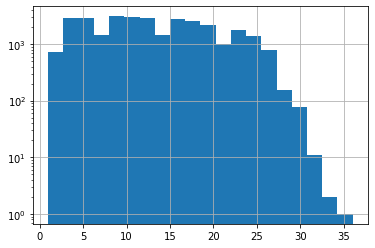

In [5]:
length_dist = train_df["text"].apply(lambda x: len(x.split()))
length_dist.hist(log=True, bins=20)

In [6]:
lengths = train_df["text"].apply(len).sort_values()
lengths

11356      2
29434      2
30583      3
7739       3
10078      3
        ... 
22648    221
23979    226
13423    400
14244    542
21872    703
Name: text, Length: 31255, dtype: int64

In [7]:
train_df["text"][21872]

'This person is the smartest person to play town of salem literally 999999999999999999999999999999999999999999999999999999999999999999999999999999999999999991000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001234567898765432345676543345678987654345678909876543234567898765432345678909876543234567898765432345678987654323456787654345676543456543456434543434343434323456765434567654323454323456543345678987654323456789876565656565656565656565656565454545654565454323456765432345678765456 IQ'

<AxesSubplot:>

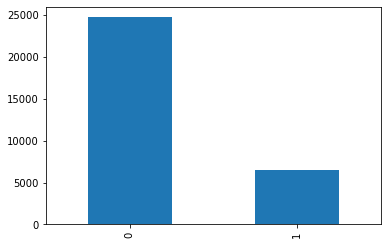

In [8]:
train_df["label"].value_counts().plot(kind="bar")

In [9]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 

Token indices sequence length is longer than the specified maximum sequence length for this model (1437 > 512). Running this sequence through the model will result in indexing errors


(array([3.125e+04, 2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([   3. ,   74.7,  146.4,  218.1,  289.8,  361.5,  433.2,  504.9,
         576.6,  648.3,  720. ,  791.7,  863.4,  935.1, 1006.8, 1078.5,
        1150.2, 1221.9, 1293.6, 1365.3, 1437. ]),
 <BarContainer object of 20 artists>)

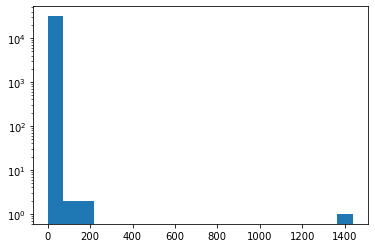

In [10]:
import matplotlib.pyplot as plt

tokenized_train = tokenizer(train_df["text"].to_list()).input_ids
lengths = [len(x) for x in tokenized_train]

plt.hist(lengths, log=True, bins=20)

In [11]:
tokenized_train = tokenizer(train_df["text"].to_list(), max_length=256, truncation=True)
tokenized_val = tokenizer(val_df["text"].to_list(), max_length=256, truncation=True)
tokenized_test = tokenizer(test_df["text"].to_list(), max_length=256, truncation=True)

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, tokenized_text, labels):
        self.tokenized_text = tokenized_text
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.tokenized_text.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = TextDataset(tokenized_train, train_df["label"].to_list())
val_dataset = TextDataset(tokenized_val, val_df["label"].to_list())
test_dataset = TextDataset(tokenized_test, test_df["label"].to_list())

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
import numpy as np

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=-1).astype(bool)
    labels = labels.astype(bool)
    
    tp = (preds & labels).astype(np.float32).sum()
    fp = (preds & ~labels).astype(np.float32).sum()
    tn = (~preds & ~labels).astype(np.float32).sum()
    fn = (~preds & labels).astype(np.float32).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1 = 2 * (precision * recall) / (precision + recall)
    acc = (tp + tn) / (tp + tn + fp + fn)
    return {"f1": f1, "acc": acc}

In [14]:
training_args = TrainingArguments(
    output_dir="results",
    logging_dir="logs",
    num_train_epochs=10,
    warmup_ratio=0.1,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=256,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_first_step=True,
    logging_steps=10,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Epoch,Training Loss,Validation Loss,F1,Acc
1,0.326200,0.400507,0.632075,0.797869
2,0.273200,0.326749,0.682051,0.857184
3,0.206900,0.327482,0.651515,0.867550
4,0.182800,0.380031,0.637298,0.857760
5,0.094200,0.547822,0.638926,0.845091
6,0.076300,0.565992,0.652983,0.844227
7,0.047900,0.640915,0.641854,0.853153
8,0.027400,0.741828,0.634898,0.849986
9,0.040100,0.782603,0.639333,0.850561
10,0.026000,0.830103,0.633872,0.849986


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForSequenceClassification.from_pretrained("results/checkpoint-735")
model = model.to(device)
model = model.eval()

In [16]:
test_dataloader = DataLoader(test_dataset, batch_size=256, collate_fn=data_collator)

In [17]:
results = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.cuda() for k,v in batch.items()}
        output = model(**batch)
        results.append(output["logits"].cpu())

In [18]:
results = torch.cat(results)
results = torch.argmax(results, dim=1)
results

tensor([1, 0, 0,  ..., 0, 0, 0])

In [19]:
submission = test_df.copy()
submission["label"] = results.numpy()
submission

,text,label
0,I was already over the edge with Cassie Zamora...,1
1,I think you're right. She has oodles of cash a...,0
2,Haha I love this. I used to give mine phone bo...,0
3,Probably out of desperation as they going no a...,0
4,Sorry !! You’re real good at that!!,0
...,...,...
8677,Yeah no...I would find it very demeaning,1
8678,This is how mafia works,0
8679,Ah thanks 👍🏻,0
8680,I ask them straight why they don't respect my ...,0


In [20]:
submission.to_csv("submission.csv", index=False)